In [1]:
import json
import ROOT
from analysis_framework import Dataset, Analysis
import os

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x7c21910


In [2]:
ROOT.EnableImplicitMT(12)

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad

In [4]:
# dataset = Dataset.from_json("data/datasets/snapshots/full.json")
# dataset = Dataset.from_json("checked-test.json")
# dataset = Dataset.from_json("checked-full.json")
dataset = Dataset.from_json("checked-signal-only-full-local.json")

In [5]:
analysis = Analysis(dataset)
# analysis.init_parameters([
#     ("Energy", "float", "-1.0"),
# ])
ROOT.gInterpreter.Declare("#include <podio/GenericParameters.h>")
analysis.Define("params_Energy", "Parameters.get<float>(\"Energy\").value_or(-1.0)")

In [6]:
analysis.set_categories({
    "4f_sw_sl_eLpL": {"pattern": "4f_sw_sl_eLpL", "cut": None},
    "4f_sw_sl_eRpL": {"pattern": "4f_sw_sl_eRpL", "cut": None},
    "4f_sw_sl_eRpR": {"pattern": "4f_sw_sl_eRpR", "cut": None},
    "4f_sw_sl_eLpR": {"pattern": "4f_sw_sl_eLpR", "cut": None},
})
# check if we missed any processes
print(analysis.is_complete_categorisation())

True


In [7]:
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_eLpL": [
    "4f_sw_sl_eLpL_signal"
  ],
  "4f_sw_sl_eRpL": [
    "4f_sw_sl_eRpL_signal"
  ],
  "4f_sw_sl_eRpR": [
    "4f_sw_sl_eRpR_signal"
  ],
  "4f_sw_sl_eLpR": [
    "4f_sw_sl_eLpR_signal"
  ]
}


In [8]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))
analysis.Define("n_neutral_PFOs", "Sum(abs(PandoraPFOs.charge) == 0.)")
analysis.Define("charged_fraction", "n_charged_PFOs / static_cast<double>(n_charged_PFOs + n_neutral_PFOs)")

In [9]:
# filter on missing energy > 0

In [10]:
# TODO: define truth objects! (Not super trivial for the quarks without truejet but should be doable)

In [11]:
# select isolated lepton and the two jets and build Ws and neutrino
analysis.Define("iso_lep_idx", "IsolatedElectrons_objIdx.index[0]")
# TODO: figure out: are isolated electrons also always Pandora electrons? :( (taking a look into the IsolatedLeptonTagging shows that this is not required!)
analysis.Define("iso_lep_lvec", "ROOT::Math::PxPyPzEVector(PandoraPFOs.momentum.x[iso_lep_idx], PandoraPFOs.momentum.y[iso_lep_idx], PandoraPFOs.momentum.z[iso_lep_idx], PandoraPFOs.energy[iso_lep_idx])")
analysis.Define("jet1_lvec", "R2jet_lvecs[0]")
analysis.Define("jet2_lvec", "R2jet_lvecs[1]")
analysis.Define("sqrt_s_E", "params_Energy")
# XXX: ignoring the electron mass here
analysis.Define("sqrt_s_lvec", f"ROOT::Math::PxPyPzEVector(sqrt_s_E * sin({x_angle}/2.), 0, 0, sqrt_s_E)")
analysis.Define("hadronic_W_lvec", "jet1_lvec + jet2_lvec")
# TODO: overlay contamination etc are still in this...
analysis.Define("leptonic_W_lvec", "sqrt_s_lvec - hadronic_W_lvec")
analysis.Define("nu_lvec", "leptonic_W_lvec - iso_lep_lvec")

In [12]:
# now we would want to remove the crossing angle
#small experiment using an actual dd4hep crossing angle boosted e+e- pair:
# e_lvec = ROOT.Math.PxPyPzMVector(+8.750143e-01, 0., +1.250000e+02, +5.109968e-04)
# p_lvec = ROOT.Math.PxPyPzMVector(+8.750143e-01, 0., -1.250000e+02, +5.109968e-04)
# s_lvec = e_lvec + p_lvec
# print(s_lvec)
# beta = s_lvec.BoostToCM()
# print(beta.x(), beta.y(), beta.z())
# boost = ROOT.Math.BoostX(beta.x())
# print(boost(s_lvec))
# print(boost(e_lvec))
# print(ROOT.Math.sin(0.007))
# boost2 = ROOT.Math.BoostX(-ROOT.Math.sin(0.007))
# print(boost2(s_lvec))
# print(boost2(e_lvec))
ROOT.gInterpreter.Declare(f"ROOT::Math::BoostX unboost_xangle(-std::sin({x_angle/2}));")
lvec_list = ["iso_lep_lvec", "jet1_lvec", "jet2_lvec", "hadronic_W_lvec", "leptonic_W_lvec", "nu_lvec"]
for lvec in lvec_list:
    analysis.Define(f"ub_{lvec}", f"unboost_xangle({lvec})")

In [ ]:
# now we want to calculate the angles as in the Hagiwara parametrisation
# TODO: is this well defined for the e+nuqq case?
# I need to be a bit careful, there can be some replacements that are only valid in zero-width CC03

In [13]:

analysis.book_histogram_1D("RecoCatAdvanced", "RecoCatAdvanced", ("", ";RecoCatAdvanced", 8, 0., 8.))
analysis.book_histogram_1D("n_isoelectrons", "n_isoelectrons", ("", ";n_isoelectrons", 5, 0., 5.))
analysis.book_histogram_1D("n_charged_PFOs", "n_charged_PFOs", ("", ";n_charged_PFOs", 50, 0., 50.))
analysis.book_histogram_1D("n_neutral_PFOs", "n_neutral_PFOs", ("", ";n_neutral_PFOs", 50, 0., 50.))
analysis.book_histogram_1D("misspT", "params_WWCategorisation_misspT", ("", ";misspT", 100, 0., 100.))
analysis.book_histogram_1D("PVertex_ndf", "PVertex_ndf", ("", ";PVertex_ndf", 50, 1., 101.))
analysis.book_histogram_1D("missE", "params_WWCategorisation_missE", ("", ";missE", 300, -50., 250.))
analysis.book_histogram_1D("mInv", "params_WWCategorisation_mInv", ("", ";mInv", 100, 40., 140.))
analysis.book_histogram_1D("M_jj", "M_jj", ("", ";M_jj", 100, 32., 132.))
analysis.book_histogram_1D("n_isomuons", "n_isomuons", ("", ";n_isomuons", 5, 0., 5.))
analysis.book_histogram_1D("PVertex_chi2", "PVertex_chi2", ("", ";PVertex_chi2", 75, 0., 150.))
analysis.book_histogram_1D("PVertex_chi2ndf", "PVertex_chi2ndf", ("", ";PVertex_chi2/ndf", 20, 0., 10.))
analysis.book_histogram_1D("charged_fraction", "charged_fraction", ("", ";charged_fraction", 50, 0., 1.))

In [14]:
analysis.book_reports()

In [15]:
%%time
analysis.run()

CPU times: user 21.6 s, sys: 3.84 s, total: 25.4 s
Wall time: 18.6 s
OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x120a9ba0


In [16]:
analysis.print_reports()

       4f_sw_sl_eLpL       4f_sw_sl_eRpL       4f_sw_sl_eRpR       4f_sw_sl_eLpR
             0 (0e+00)             0 (0e+00)             0 (0e+00)             0 (0e+00) All
         0e+00         0e+00         0e+00         0e+00 efficiency


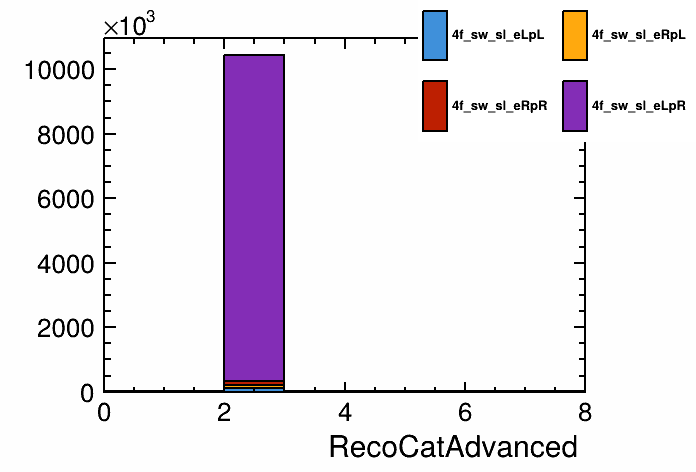

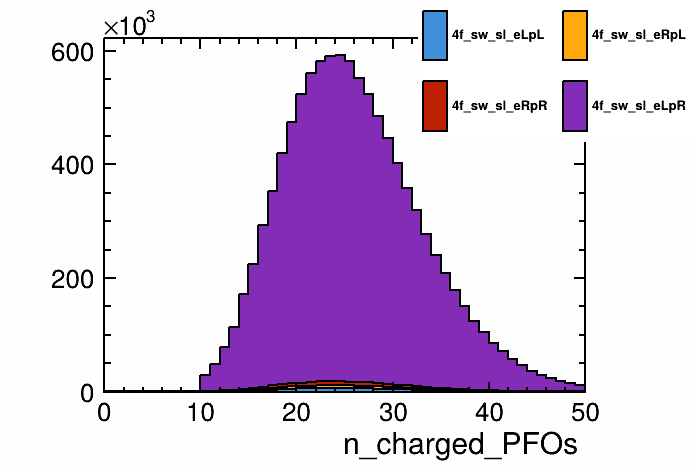

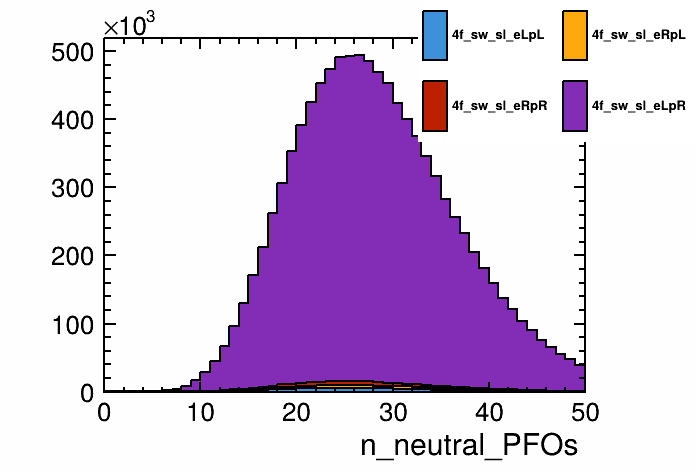

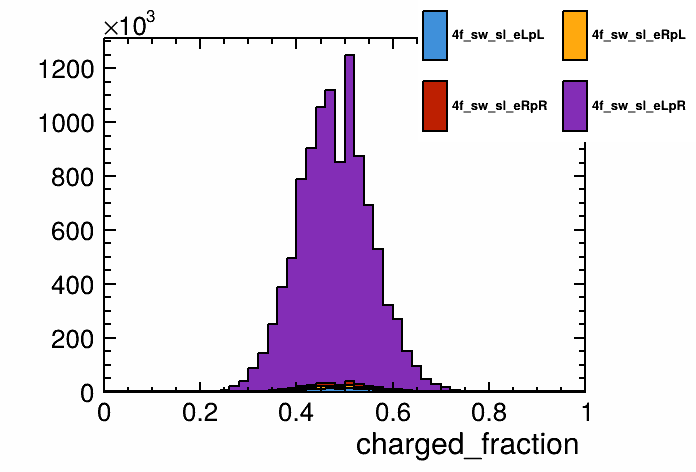

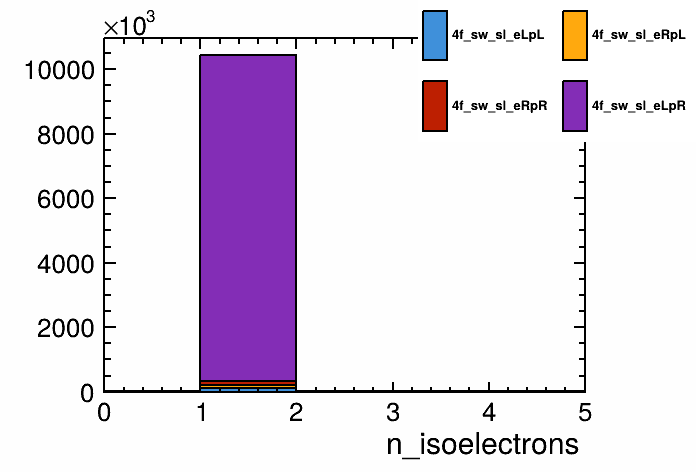

In [17]:
# unfortunately the jsroot plots break all the time, maybe it is just too much for them
# %jsroot on
# 0 - hadronic (both W decay hadronically)
# 1 - invisible semileptonic (one W decays hadronically, but the lepton is not within detector acceptance/detected)
# 2 - semileptonic electron
# 3 - semileptonic muon
# 4 - semileptonic tauon
# 5 - leptonic (both W decay leptonically)
# 6 - other, 7- broken?
analysis.draw_histogram("RecoCatAdvanced")
analysis.draw_histogram("n_charged_PFOs")
analysis.draw_histogram("n_neutral_PFOs")
analysis.draw_histogram("charged_fraction")
analysis.draw_histogram("n_isoelectrons")

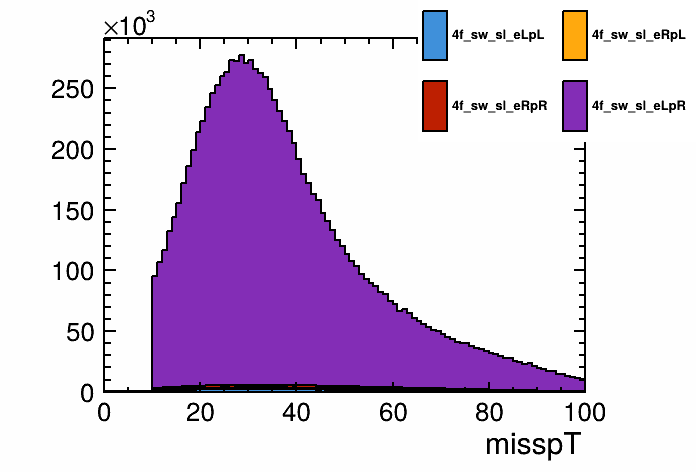

In [18]:
analysis.draw_histogram("misspT")

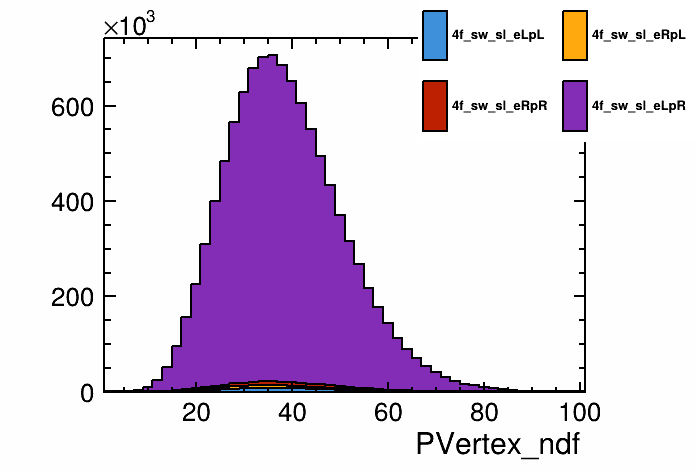

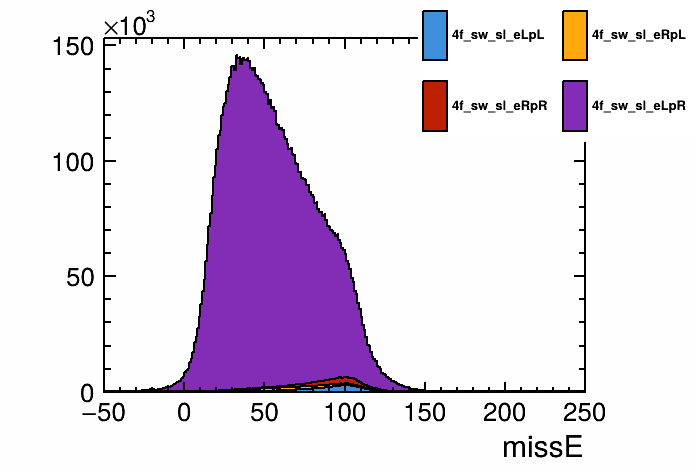

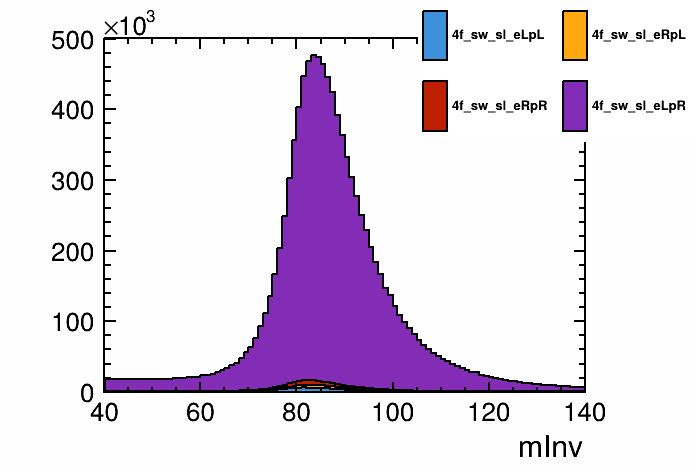

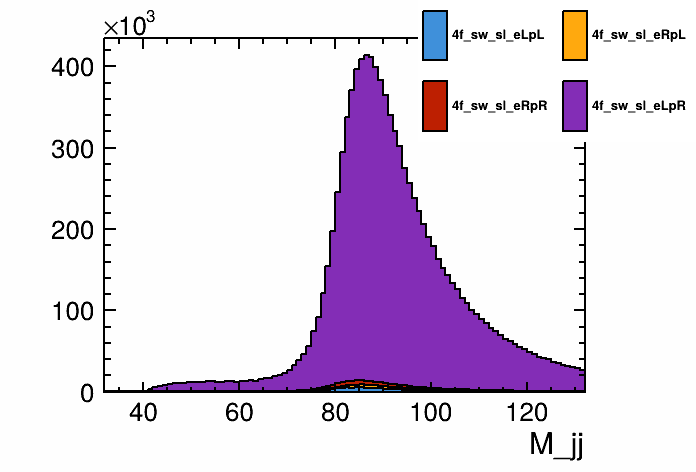

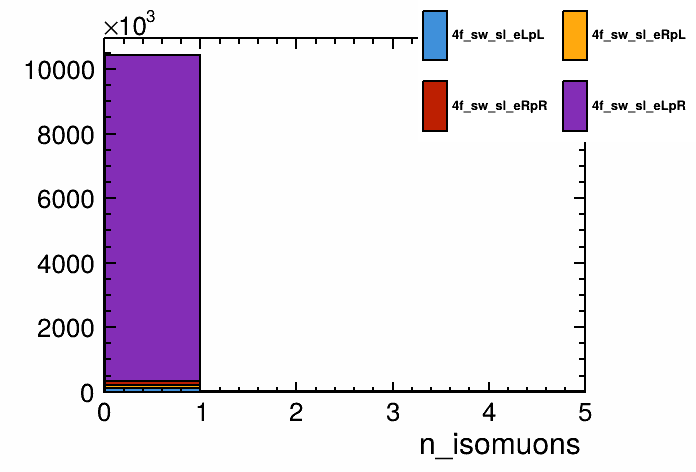

In [19]:
analysis.draw_histogram("PVertex_ndf")

analysis.draw_histogram("missE")
analysis.draw_histogram("mInv")
analysis.draw_histogram("M_jj")
analysis.draw_histogram("n_isomuons")

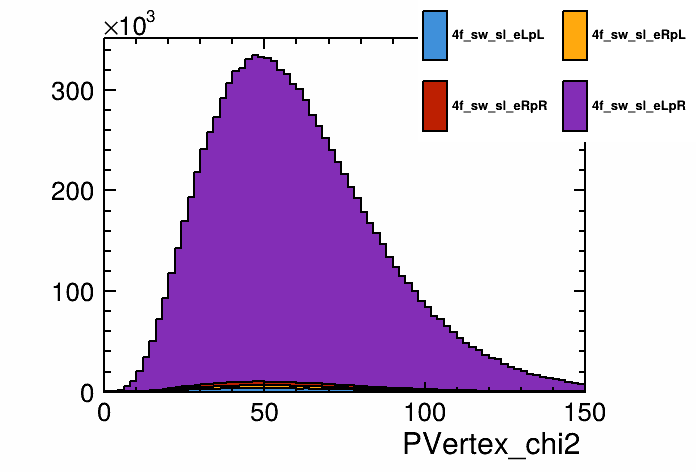

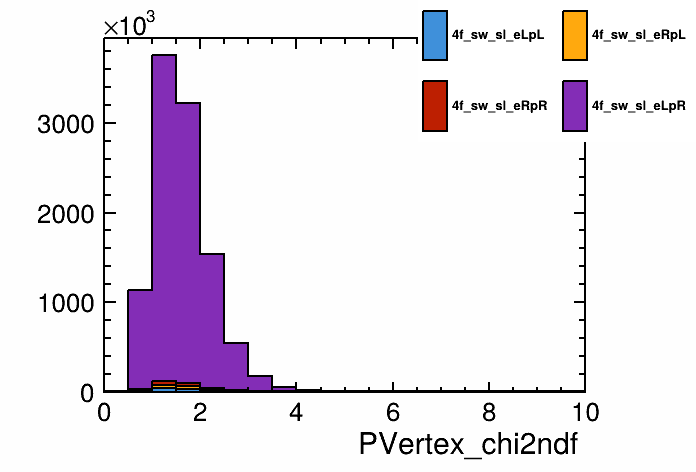

In [20]:
analysis.draw_histogram("PVertex_chi2")
analysis.draw_histogram("PVertex_chi2ndf")

In [21]:
# TODO: plot the 5 (10?) differential cross sections down here